<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (0.5 балла)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
from torch.utils.data import DataLoader
from torchvision.transforms import v2


IMG_SIZE = 128, 128
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# np.random.seed(MAGIC_NUMER)
# torch.manual_seed(MAGIC_NUMER)
# torch.cuda.manual_seed(MAGIC_NUMER).

train_ds = ImageFolder(
    "photo",
    transform=v2.Compose(
        [
            v2.Resize(IMG_SIZE),
            v2.CenterCrop(IMG_SIZE),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [3]:
from typing import Literal


class ConvBlock(nn.Module):
    def __init__(self, inp: int, out: int, kernel_size: int, stride=1, padding=1, act: Literal['relu', 'leaky']='relu'):
        super().__init__()
        self.act = nn.LeakyReLU(0.2, inplace=True) if act == 'leaky' else nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(inp, out, kernel_size, stride, padding, bias=False)
        self.norm = nn.BatchNorm2d(out)

    def forward(self, x):
        out = self.act(self.norm(self.conv(x)))
        return out


class ConvResizeX2(ConvBlock):
    def __init__(self, inp: int, out: int, kernel_size: int, stride=1, padding=1):
        super().__init__(inp, out, kernel_size, stride, padding)
        self.conv = nn.ConvTranspose2d(inp, out, kernel_size, stride, padding, bias=False)

In [4]:
from lib.weights_init import weights_init


class Generator(nn.Module):
    LATENT_SIZE = 128
    name = "generator"

    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            ConvResizeX2(self.LATENT_SIZE, 1024, kernel_size=4, stride=1, padding=0),
            ConvBlock(1024, 1024, kernel_size=3, padding=1),
            ConvResizeX2(1024, 512, kernel_size=4, stride=2, padding=1),
            ConvBlock(512, 512, kernel_size=3, padding=1),
            ConvResizeX2(512, 256, kernel_size=4, stride=2, padding=1),
            ConvBlock(256, 256, kernel_size=3, padding=1),
            ConvResizeX2(256, 256, kernel_size=4, stride=2, padding=1),
            ConvBlock(256, 256, kernel_size=3, padding=1),
            ConvResizeX2(256, 128, kernel_size=4, stride=2, padding=1),
            ConvBlock(128, 128, kernel_size=3, padding=1),
            ConvResizeX2(128, 64, kernel_size=4, stride=2, padding=1),
            ConvBlock(64, 32, kernel_size=3, padding=1),
            nn.Conv2d(32, 3, kernel_size=3, padding=1, bias=False),
            nn.Tanh(),
        )
        self.apply(weights_init)

    def forward(self, x):
        return self.main(x)

    def gen_latent(self, batch: int):
        return torch.randn((batch, self.LATENT_SIZE, 1, 1))


In [5]:
class Discriminator(nn.Module):
    name = "discriminator"

    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            ConvBlock(3, 64, kernel_size=3, stride=2, padding=1),  # 128 -> 64
            ConvBlock(64, 64, kernel_size=3, stride=1, padding=1),
            ConvBlock(64, 128, kernel_size=3, stride=2, padding=1),  # 64 -> 32
            ConvBlock(128, 128, kernel_size=3, stride=1, padding=1),
            ConvBlock(128, 256, kernel_size=3, stride=2, padding=1),  # 32 -> 16
            ConvBlock(256, 256, kernel_size=3, stride=1, padding=1),
            ConvBlock(256, 512, kernel_size=3, stride=2, padding=1),  # 16 -> 8
            ConvBlock(512, 1024, kernel_size=3, stride=1, padding=1),
            ConvBlock(1024, 1024, kernel_size=3, stride=2, padding=1),  # 8 -> 4
            ConvBlock(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(1024, 1, kernel_size=4, stride=2, padding=0, bias=False),  # 4 -> 1
            nn.Flatten(),
            nn.Sigmoid(),
        )
        self.apply(weights_init)

    def forward(self, x):
        return self.main(x)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [6]:
IMG_TRANSFORM = v2.ToPILImage()

def gen_latent(batch: int):
    return torch.randn((batch, Generator.LATENT_SIZE, 1, 1))


def show_pictures(
    imgs: list[list[torch.Tensor]],
    preds: list[list[torch.Tensor]] = None,
    rows: int = 1,
    cols: int = 5,
    title: str = None,
):
    figure, axs = plt.subplots(rows, cols)
    figure.set_figheight(rows * 3 + 2)
    figure.set_figwidth(cols * 4 + 2)

    if title is not None:
        figure.suptitle(title)

    for i in range(rows):

        for j in range(cols):
            img = IMG_TRANSFORM(imgs[i*rows+j]*0.5 + 0.5)

            axs[i][j].imshow(img, aspect="auto")
            axs[i][j].axis("off")
            if preds is not None:
                axs[i][j].set_title(f"{preds[i][j].item():.5f}")
    figure.show()

In [7]:
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

model = {
        "generator": generator,
        "discriminator": discriminator,
    }
loss_f = {
    "generator": torch.nn.BCELoss().to(DEVICE),
    "discriminator": torch.nn.BCELoss().to(DEVICE),
}

optimizer = {
    "generator": torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5, 0.95)),
    "discriminator": torch.optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.5, 0.95)),
}
schedule = {
    "generator": torch.optim.lr_scheduler.StepLR(optimizer["generator"], 20, 0.5),
    "discriminator": torch.optim.lr_scheduler.StepLR(optimizer["discriminator"], 20, 0.5),
}

In [8]:
def train(model, loss_f, optimizer, train_dl):
        """Одна эпоха обучения модели."""
        generator, discriminator = model['generator'], model['discriminator']
        generator.train()
        discriminator.train()
        loss_discriminator = []
        loss_generator = []

        for photos, _ in tqdm(train_dl):
            photos = photos.to(DEVICE)
            labels_real = torch.ones((photos.size(0), 1), device=DEVICE)
            labels_fake = torch.zeros((photos.size(0), 1), device=DEVICE)

            # discriminator
            optimizer["discriminator"].zero_grad()
            preds_real = discriminator(photos)
            loss_real = loss_f["discriminator"](preds_real, labels_real)

            latent = gen_latent(photos.size(0)).to(DEVICE)
            fake_photos = generator(latent).detach()
            preds_fake = discriminator(fake_photos)
            loss_fake = loss_f["discriminator"](preds_fake, labels_fake)

            loss = loss_fake + loss_real
            loss.backward()
            optimizer["discriminator"].step()
            loss_discriminator.append(loss.cpu().item())

            # generator
            optimizer["generator"].zero_grad()
            latent = gen_latent(photos.size(0)).to(DEVICE)
            fake_photos = generator(latent)
            preds = discriminator(fake_photos)
            loss_fake = loss_f["generator"](preds, labels_real)

            loss_fake.backward()
            optimizer["generator"].step()
            loss_generator.append(loss_fake.cpu().item())

        return np.mean(loss_generator), np.mean(loss_discriminator)

In [9]:
LOG_TEMPLATE = (
  "Epoch {ep:03d}\nGenerator: train - {t_loss_gen:0.6f};"
  + "\nDiscriminator: train - {t_loss_desc:0.6f};"
)
STEP_SAVE = 5


def fit(model, train_dl, loss_f, optimizer, scheduler, epochs):
  generator, discriminator = model['generator'], model['discriminator']
  history = {"generator": [], "discriminator": []}
  predicts = []
  imgs = []

  try:
    for epoch in range(1, epochs + 1):
        print(f"Epoch: {epoch}")
        t_loss_gen, t_loss_desc = train(model, loss_f, optimizer, train_dl)
        scheduler.step()

        history["generator"].append(t_loss_gen)
        history["discriminator"].append(t_loss_desc)

        print(
            LOG_TEMPLATE.format(
                ep=epoch,
                t_loss_gen=t_loss_gen,
                t_loss_desc=t_loss_desc,
            ),
            "\n" + "-" * 56,
        )

        latent = gen_latent(10).to(DEVICE)
        with torch.no_grad():
            fake_photos = generator(latent)
            preds = discriminator(fake_photos)

        imgs.append(fake_photos)
        predicts.append(preds)

        if epoch % STEP_SAVE == 0:
            show_pictures(imgs, predicts)
            imgs = []
            predicts = []
  except KeyboardInterrupt():
     print('Предварительное окончание')
     return history

---
**Мысли автора**

Обучение происходило локально в файлах (не в .ipynb). Поэтому веса уже обученной модели подгружаем.

---

In [10]:
def load(model, path: str):
    model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()
    return model


discriminator = load(discriminator, './models/GAN/21-12-2024_10-07/Discriminator/model')
generator = load(generator, './models/GAN/21-12-2024_10-07/Generator/model')

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

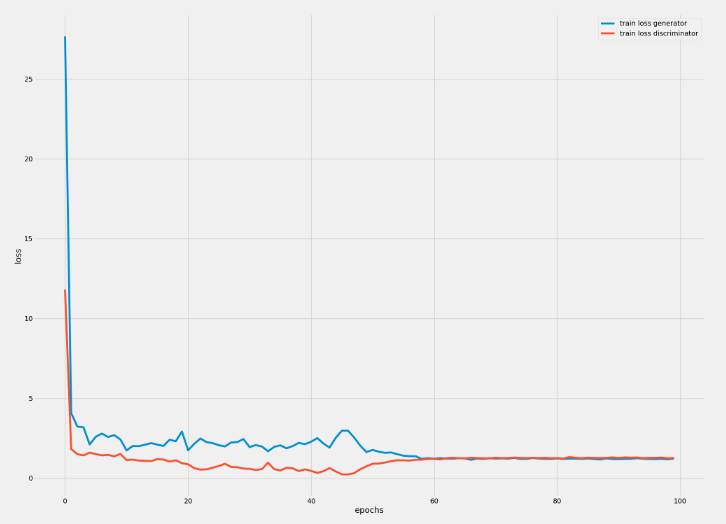

---
**Мысли автора**

В целом состязание у моделей удалось, но из-за того, что дискриминатор не особо хорошо распознавал реальные/фейковые изображения, GAN не смог хорошо обучиться.

---

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

C:\Users\LicrimoVor\AppData\Local\Temp\ipykernel_12284\1000452838.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


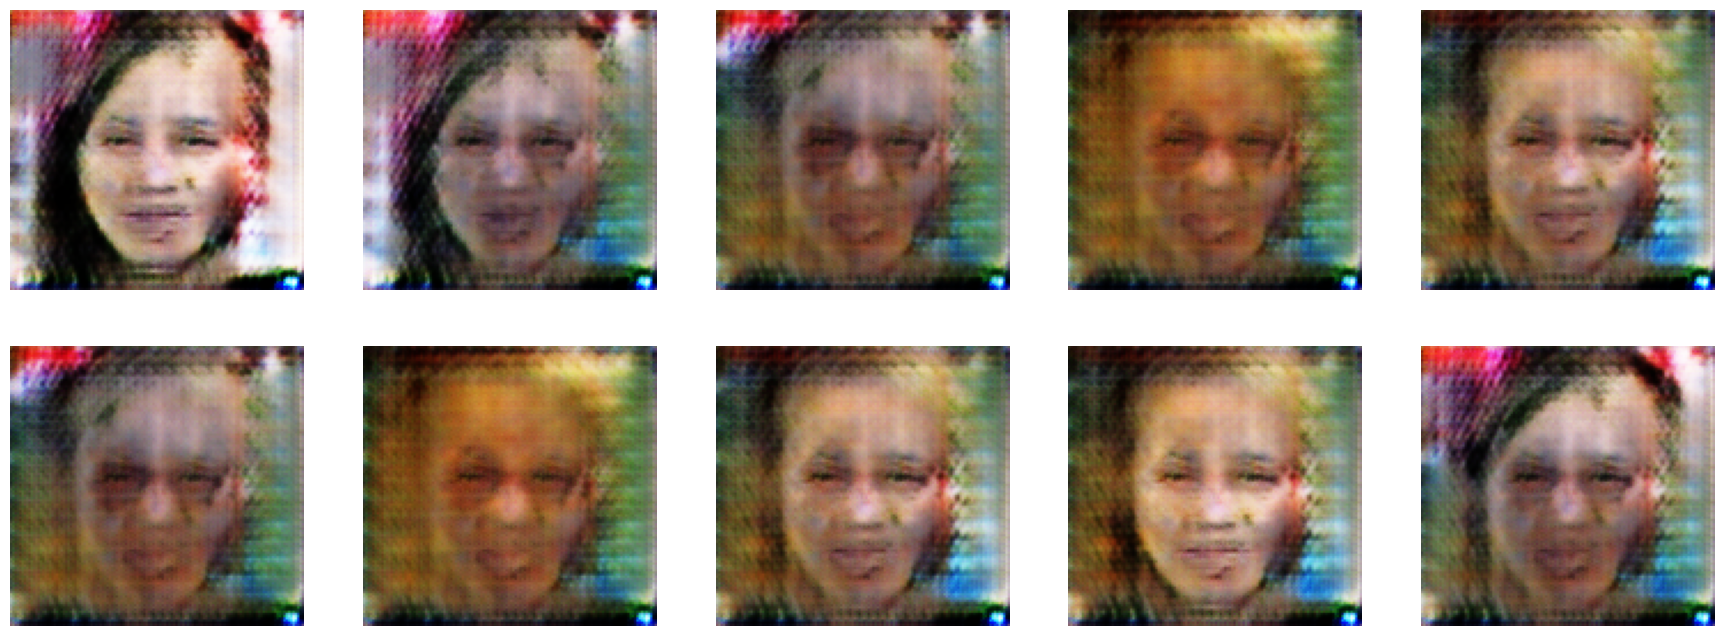

In [11]:
n_images = 10

fixed_latent = torch.randn(10, Generator.LATENT_SIZE, 1, 1, device=DEVICE)
fake_images = model["generator"](fixed_latent)
show_pictures(fake_images, rows=2, cols=5)

Как вам качество получившихся изображений?

---
**Мысли автора**

Я просидел 3 дня с этим... Я доволен)

---

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (1.5 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [12]:
from pathlib import Path

from PIL import Image
from torch.utils.data import Dataset


class DatasetPhoto(Dataset):
    def __init__(self, paths: list[Path], labels: list[int]):
        super().__init__()
        self.paths = paths
        self.labels = labels

        self.transformers = v2.Compose([
                v2.Resize(IMG_SIZE),
                v2.CenterCrop(IMG_SIZE),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    def load_img(self, path: Path):
        img = Image.open(path)
        img.load()
        return img

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, int]:
        path = self.paths[index]
        photo = self.load_img(path)
        photo = self.transformers(photo)

        return photo, self.labels[index]


In [13]:
from torchvision.transforms.functional import to_pil_image


for i, _ in enumerate(train_ds): 
    latent = torch.randn(1, Generator.LATENT_SIZE, 1, 1, device=DEVICE)
    with torch.no_grad():
        photo = generator(latent)
    img = to_pil_image(photo[0]*0.5 + 0.5)
    img.save(open(f'./fake/{i}.png', mode='wb'))

In [14]:
real_paths = list(Path("./photo/faces_dataset_small").iterdir())
fake_paths = list(Path("./fake").iterdir())
print(len(real_paths), len(fake_paths))
all_paths = real_paths + fake_paths
labels = [1] * len(real_paths) + [0] * len(real_paths)

knn_ds = DatasetPhoto(all_paths, labels)

3143 3143


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
count = 1
iterator = iter(loo.split(knn_ds))
history = []

for _ in range(count):
    indx_trains, (indx_test, ) = next(iterator)
    knn = KNeighborsClassifier(n_neighbors=1)

    photos = torch.empty(1, 128*128*3)
    labels = []
    for j, indx in tqdm(enumerate(indx_trains), total=len(indx_trains)):
        photo, label = knn_ds[indx]
        photos = torch.concat((photos, photo.reshape(1, 128*128*3)), dim=0)
        labels.append(label)

        if j % BATCH_SIZE == 15:
            knn.fit(photos[1:], labels)
            photos = torch.empty(1, 128*128*3)
            labels = []

    knn.fit(photos[1:], labels)

    photo, label = knn_ds[indx_test]
    predict = knn.predict(photo.reshape(1, 128*128*3))
    history.append(predict)

  0%|          | 0/6285 [00:00<?, ?it/s]

In [17]:
history

[array([0])]

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

---
**Мысли автора**

Фотографии может отличить даже KNN)

---

### 4.2. Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [18]:
photos = [photo for photo, _ in knn_ds]
all_images = torch.hstack(photos).numpy().reshape(-1,128*128*3)

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_jobs=2,)
embedded = tsne.fit_transform(all_images)

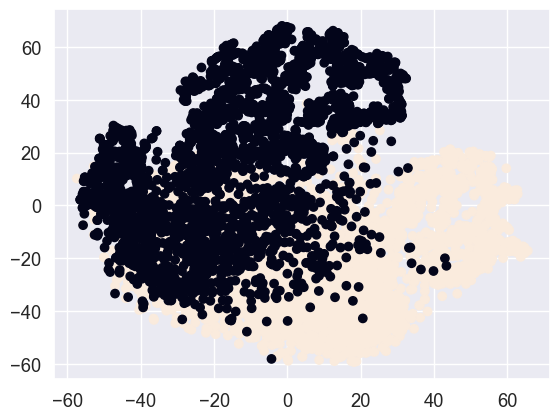

In [22]:
plt.scatter(embedded[:, 0], embedded[:, 1], c=knn_ds.labels)
plt.show()

Прокомментируйте получившийся результат:

---
**Мысли автора**

Ну... В целом... Не так плохо, как могло бы быть. Есть какое то совпадение в большой области, а так очень сильное расхождение.

---